In [4]:
from pyspark.sql import SparkSession
from pyspark.sql import functions as F, types as T

In [ ]:
spark = (SparkSession
         .builder
         .appName("Recipees ML Model")
         .getOrCreate()
)

In [8]:
path = "/".join("\\sparkdata\\DataAnalysisWithPythonAndPySpark-Data\\recipes".split("\\"))

Exploring, understand, preparing and giving purpose to the data.

# Reading, exploring, and preparing the data set

In [9]:
food = spark.read.csv(
    path+"/epi_r.csv", inferSchema=True, header=True
)

In [10]:
print(food.count(),len(food.columns))

20057 680


In [12]:
food.printSchema()

root
 |-- title: string (nullable = true)
 |-- rating: string (nullable = true)
 |-- calories: string (nullable = true)
 |-- protein: double (nullable = true)
 |-- fat: double (nullable = true)
 |-- sodium: double (nullable = true)
 |-- #cakeweek: double (nullable = true)
 |-- #wasteless: double (nullable = true)
 |-- 22-minute meals: double (nullable = true)
 |-- 3-ingredient recipes: double (nullable = true)
 |-- 30 days of groceries: double (nullable = true)
 |-- advance prep required: double (nullable = true)
 |-- alabama: double (nullable = true)
 |-- alaska: double (nullable = true)
 |-- alcoholic: double (nullable = true)
 |-- almond: double (nullable = true)
 |-- amaretto: double (nullable = true)
 |-- anchovy: double (nullable = true)
 |-- anise: double (nullable = true)
 |-- anniversary: double (nullable = true)
 |-- anthony bourdain: double (nullable = true)
 |-- aperitif: double (nullable = true)
 |-- appetizer: double (nullable = true)
 |-- apple: double (nullable = true)


## Standardizing column names using toDF()

In [13]:
def sanitize_column_name(name):
    """Drops unwanted characters from the column name.
    
    We replace spaces, dashes and slashes with underscore,
    and only keep alphanumeric characters."""
    answer = name
    for i, j in ((" ", "_"), ("-", "_"), ("/", "_"), ("&", "and")):
        answer = answer.replace(i, j)
    return "".join(
        [
            char
            for char in answer
            if char.isalpha() or char.isdigit() or char == "_"
        ]
    )
    
food = food.toDF(*[sanitize_column_name(name) for name in food.columns])

## Feature columns, data exploration

In [17]:
'''
for x in food.columns:
    food.select(x).summary().show()
'''
food.select(food.columns[3]).summary().show()

+-------+------------------+
|summary|           protein|
+-------+------------------+
|  count|             15891|
|   mean|100.19911427852243|
| stddev| 3840.199434541588|
|    min|               0.0|
|    25%|               3.0|
|    50%|               8.0|
|    75%|              27.0|
|    max|          236489.0|
+-------+------------------+



for single node: pandas-profiling library.


### Numerical features
We have continuous and categorical data.
* Categorical
    * binary, ordinal (ordering matters), nominal(no specific ordering)
 
Indetifying the variables is crucial for data preparations, and for the performance of the ML model.

<div>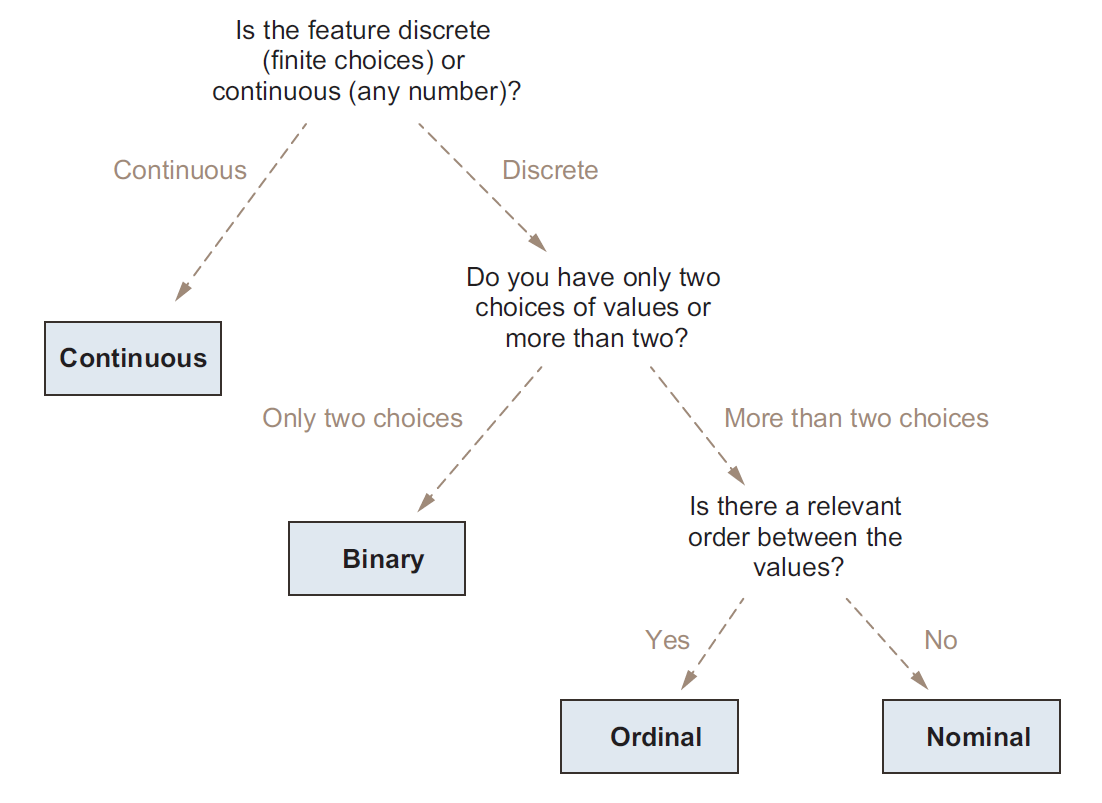</div>

### Identifying Binary columns

In [19]:
import pandas as pd

pd.set_option("display.max_rows", 10)

is_binary = food.agg(
    *[
        (F.size(F.collect_set(x)) == 2).alias(x)
        for x in food.columns
    ]
).toPandas()

is_binary.unstack()

title       0    False
rating      0    False
calories    0    False
protein     0    False
fat         0    False
                 ...  
cookbooks   0     True
leftovers   0     True
snack       0     True
snack_week  0     True
turkey      0     True
Length: 680, dtype: bool

## Addressing data mishaps and building first feature set

In [20]:
food.agg(*[F.collect_set(x) for x in ("cakeweek", "wasteless")]).show(
    1, False
)

+-------------------------------+----------------------+
|collect_set(cakeweek)          |collect_set(wasteless)|
+-------------------------------+----------------------+
|[0.0, 1.0, 1188.0, 24.0, 880.0]|[0.0, 1.0, 1439.0]    |
+-------------------------------+----------------------+



In [22]:
food.where("cakeweek > 1.0 or wasteless > 1.0").select(
    "title", "rating", "wasteless", "cakeweek", food.columns[-1]
).show(truncate=False)

+----------------------------------------------------------------+------------------------+---------+--------+------+
|title                                                           |rating                  |wasteless|cakeweek|turkey|
+----------------------------------------------------------------+------------------------+---------+--------+------+
|"Beet Ravioli with Pine Nut ""Goat Cheese"" Rosemary-Cream Sauce| Aged Balsamic Vinegar "|0.0      |880.0   |0.0   |
|"Seafood ""Cataplana"" with Saffron                             | Vermouth               |1439.0   |24.0    |0.0   |
|"""Pot Roast"" of Seitan                                        | Aunt Gloria-Style "    |0.0      |1188.0  |0.0   |
+----------------------------------------------------------------+------------------------+---------+--------+------+



In [23]:
# Keeping only legit values for wasteless and cakeweek
food = food.where(
    (
        F.col("cakeweek").isin([0.0, 1.0])
        | F.col("cakeweek").isNull()
    )
    & (
        F.col("wasteless").isin([0.0, 1.0])
        | F.col("wasteless").isNull()
    )
)
print(food.count(), len(food.columns))

20054 680


In [24]:
# top-level variables -> easire to reference

IDENTIFIERS = ["title"]

CONTINUOUS_COLUMNS = [
    "rating",
    "calories",
    "protein",
    "fat",
    "sodium",
]

TARGET_COLUMN = ["dessert"]

BINARY_COLUMNS = [
    x
    for x in food.columns
    if x not in CONTINUOUS_COLUMNS
    and x not in TARGET_COLUMN
    and x not in IDENTIFIERS
]

## Weeding out useless records and imputing binary features

records where all features are null/target is null

In [25]:
food = food.dropna(
    how="all",
    subset=[x for x in food.columns if x not in IDENTIFIERS],
)

food = food.dropna(subset=TARGET_COLUMN)

print(food.count(), len(food.columns))

20049 680


In [26]:
#Setting deafult value of 0 to every binary feature column
food = food.fillna(0.0, subset=BINARY_COLUMNS)

print(food.where(F.col(BINARY_COLUMNS[0]).isNull()).count()) # => 0

0


## Cleaning continuous columns

In [27]:
#non numerical values in rating and calories

from typing import Optional

@F.udf(T.BooleanType())
def is_a_number(value: Optional[str]) -> bool:
    if not value:
        return True
    try:
        _ = float(value)
    except ValueError:
        return False
    return True

food.where(~is_a_number(F.col("rating"))).select(
    *CONTINUOUS_COLUMNS
).show()

+---------+------------+-------+----+------+
|   rating|    calories|protein| fat|sodium|
+---------+------------+-------+----+------+
| Cucumber| and Lemon "|   3.75|NULL|  NULL|
+---------+------------+-------+----+------+



In [28]:
## casting rating and calories as double

for column in ["rating", "calories"]:
    food = food.where(is_a_number(F.col(column)))
    food = food.withColumn(column, F.col(column).cast(T.DoubleType()))
    
print(food.count(), len(food.columns))

20048 680


In [29]:
## checking continuous features
food.select(*CONTINUOUS_COLUMNS).summary(
"mean",
"stddev",
"min",
"1%",
"5%",
"50%",
"95%",
"99%",
"max",
).show()

+-------+------------------+------------------+------------------+------------------+-----------------+
|summary|            rating|          calories|           protein|               fat|           sodium|
+-------+------------------+------------------+------------------+------------------+-----------------+
|   mean| 3.714460295291301|6324.0634571930705|100.17385283565179| 346.9398083953107|6226.927244193346|
| stddev|1.3409187660508972| 359079.8369634022|3840.6809971287344|20458.040344124118|333349.5680370267|
|    min|               0.0|               0.0|               0.0|               0.0|              0.0|
|     1%|               0.0|              18.0|               0.0|               0.0|              1.0|
|     5%|               0.0|              62.0|               0.0|               0.0|              5.0|
|    50%|             4.375|             331.0|               8.0|              17.0|            294.0|
|    95%|               5.0|            1316.0|              75.

In [30]:
# Removeing 99% percentile of features
maximum = {
    "calories": 3203.0,
    "protein": 173.0,
    "fat": 207.0,
    "sodium": 5661.0,
}

for k, v in maximum.items():
    food = food.withColumn(
        k,
        F.when(F.isnull(F.col(k)), F.col(k)).otherwise(
            F.least(F.col(k), F.lit(v))
        ),
    )

## Weeding out low frequency features

If every recipe has a certain feature as true (i.e., too many 1s or 0s), then said feature does not discriminate properly.

In [31]:
# Removing binary featuers that happen too little or too often

inst_sum_of_binary_columns = [
    F.sum(F.col(x)).alias(x) for x in BINARY_COLUMNS
]

sum_of_binary_columns = (
    food.select(*inst_sum_of_binary_columns).head().asDict()
)

num_rows = food.count()

too_rare_features = [
    k
    for k, v in sum_of_binary_columns.items()
    if v < 10 or v > (num_rows - 10)
]

len(too_rare_features) # => 167

print(too_rare_features)
# ['cakeweek', 'wasteless', '30_days_of_groceries',
# [...]
# 'yuca', 'cookbooks', 'leftovers']
BINARY_COLUMNS = list(set(BINARY_COLUMNS) - set(too_rare_features))

['cakeweek', 'wasteless', '30_days_of_groceries', 'alabama', 'alaska', 'anthony_bourdain', 'apple_juice', 'arizona', 'aspen', 'atlanta', 'australia', 'beverly_hills', 'biscuit', 'boston', 'bran', 'brooklyn', 'brownie', 'buffalo', 'bulgaria', 'burrito', 'cambridge', 'camping', 'canada', 'caviar', 'chicago', 'chili', 'cobbler_crumble', 'columbus', 'cook_like_a_diner', 'cookbook_critic', 'costa_mesa', 'cranberry_sauce', 'crêpe', 'crme_de_cacao', 'cuba', 'cupcake', 'custard', 'dallas', 'denver', 'digestif', 'dominican_republic', 'dorie_greenspan', 'eau_de_vie', 'egg_nog', 'egypt', 'emeril_lagasse', 'england', 'entertaining', 'epi__ushg', 'epi_loves_the_microwave', 'flat_bread', 'frankenrecipe', 'freezer_food', 'friendsgiving', 'frittata', 'fritter', 'germany', 'grains', 'grand_marnier', 'granola', 'grappa', 'guam', 'haiti', 'hamburger', 'hawaii', 'healdsburg', 'hollywood', 'house_cocktail', 'houston', 'hummus', 'iced_coffee', 'idaho', 'illinois', 'indiana', 'iowa', 'israel', 'italy', 'jama

# Feature engineering and refinement

## Creating custom features

In [32]:
## features that add ratio of protein and fat in the recipe
food = food.withColumn(
    "protein_ratio", F.col("protein") * 4 / F.col("calories")
).withColumn(
    "fat_ratio", F.col("fat") * 9 / F.col("calories")
)

food = food.fillna(0.0, subset=["protein_ratio", "fat_ratio"])

CONTINUOUS_COLUMNS += ["protein_ratio", "fat_ratio"]

## Removing highly correlated features

use Spark _Correlation_ object

In [33]:
from pyspark.ml.feature import VectorAssembler ## the _Correlation_ object will use a method _corr_ that computes the correlation between features in a vector.

continuous_features = VectorAssembler(
    inputCols=CONTINUOUS_COLUMNS, outputCol="continuous_features"
)

vector_food = food.select(CONTINUOUS_COLUMNS)
for x in CONTINUOUS_COLUMNS:
    vector_food = vector_food.where(~F.isnull(F.col(x))) ## vectors cannot have null values
    
vector_variable = continuous_features.transform(vector_food)

vector_variable.select("continuous_features").show(3, False)

+---------------------------------------------------------------------+
|continuous_features                                                  |
+---------------------------------------------------------------------+
|[2.5,426.0,30.0,7.0,559.0,0.28169014084507044,0.14788732394366197]   |
|[4.375,403.0,18.0,23.0,1439.0,0.17866004962779156,0.5136476426799007]|
|[3.75,165.0,6.0,7.0,165.0,0.14545454545454545,0.38181818181818183]   |
+---------------------------------------------------------------------+
only showing top 3 rows



In [38]:
from pyspark.ml.stat import Correlation

#takes a dataframe and a vector column, returning a single-row, single-column data frame containing the corr. matrix
correlation = Correlation.corr(
    vector_variable, "continuous_features"
) 

correlation.printSchema()


root
 |-- pearson(continuous_features): matrix (nullable = false)



In [46]:
correlation_array = correlation.head()[0].toArray()

correlation_pd = pd.DataFrame(
    correlation_array,
    index=CONTINUOUS_COLUMNS,
    columns=CONTINUOUS_COLUMNS,
)

print(correlation_pd.iloc[:, :4])

                 rating  calories   protein       fat
rating         1.000000  0.102257  0.113292  0.111536
calories       0.102257  1.000000  0.757837  0.918052
protein        0.113292  0.757837  1.000000  0.664899
fat            0.111536  0.918052  0.664899  1.000000
sodium         0.065225  0.516818  0.585450  0.421920
protein_ratio  0.094429  0.164735  0.600182  0.125572
fat_ratio      0.129946  0.176823  0.109188  0.424986


Decide whether to use highly correlated featuers.

# Feature preparation with transformers and estimators

Transformers are components that transform raw data into a format suitable for modeling or further processing. They implement a transform method, which takes an input DataFrame and produces a new DataFrame with additional columns containing the transformed data. Transformers don't learn from data; they simply apply predefined transformations. 

Estimators, on the other hand, are components that can be fit to data to produce a model. They implement a fit method, which takes an input DataFrame and returns a model (or transformer). Estimators in Spark MLlib typically represent algorithms or models that learn from data. 

## Imputing continuous features using the Imputer estimator

In [49]:
from pyspark.ml.feature import Imputer

OLD_COLS = ["calories", "protein", "fat", "sodium"]
NEW_COLS = ["calories_i", "protein_i", "fat_i", "sodium_i"]

imputer = Imputer(
    strategy="mean",
    inputCols=OLD_COLS,
    outputCols=NEW_COLS,
)

imputer_model = imputer.fit(food)

CONTINUOUS_COLUMNS = (
    list(set(CONTINUOUS_COLUMNS) - set(OLD_COLS)) + NEW_COLS
)



In [50]:
food_imputed = imputer_model.transform(food)

food_imputed.where("calories is null").select("calories", "calories_i").show(
    5, False
)

+--------+-----------------+
|calories|calories_i       |
+--------+-----------------+
|NULL    |475.5222194325885|
|NULL    |475.5222194325885|
|NULL    |475.5222194325885|
|NULL    |475.5222194325885|
|NULL    |475.5222194325885|
+--------+-----------------+
only showing top 5 rows



## MinMaxScaler

In [52]:
from pyspark.ml.feature import MinMaxScaler

CONTINUOUS_NB = [x for x in CONTINUOUS_COLUMNS if "ratio" not in x]

continuous_assembler = VectorAssembler(
    inputCols=CONTINUOUS_NB, outputCol="continuous"
)

food_features = continuous_assembler.transform(food_imputed)

continuous_scaler = MinMaxScaler(
    inputCol="continuous",
    outputCol="continuous_scaled",
)

food_features = continuous_scaler.fit(food_features).transform(
    food_features
)


In [53]:
food_features.select("continuous_scaled").show(3, False)

+-----------------------------------------------------------------------------------------+
|continuous_scaled                                                                        |
+-----------------------------------------------------------------------------------------+
|[0.5,0.13300031220730565,0.17341040462427745,0.033816425120772944,0.09874580462815757]   |
|[0.875,0.12581954417733376,0.10404624277456646,0.1111111111111111,0.2541953718424307]    |
|[0.75,0.051514205432407124,0.03468208092485549,0.033816425120772944,0.029146793852676208]|
+-----------------------------------------------------------------------------------------+
only showing top 3 rows

